In [2]:
import numpy as np
import matplotlib.pyplot as plt
from utils import *
from pathlib import Path
path_output_dir = Path('/media/arthur/DATA/Data sets/outputs/pyqg/StrongSheark')
%matplotlib notebook

To do
- make it for both layers at the same time
- this includes the similarity measures, although per-layer values should also be available
- videos
- automatic use of saved L value, reading of forcing value, reading of filter values
- fft_coarsening

In [5]:
layer_index = 0
delta = 0.25
def to_barotropic(u, v, delta):
    u_baro = 1 / (delta + 1) * (delta * u[:, 0] + u[:, 1])
    v_baro = 1 / (delta + 1) * (delta * v[:, 0] + v[:, 1])
    return np.stack((u_baro, v_baro), axis=1)

In [6]:
names = ['64', '64_param', '256']
uv = dict(zip(names, [dict() for i in range(3)]))
for name in names:
    if name == '64_param':
        name_ = '64_1.8395579594799456_7.535791984347996param'
        name_ = '64_1_1param'
        name_ = '64_8.76678375101098_7.696759627883999param'
        name_ = '64_2.651978263976365_1param'
        name_ = '64_1.729036647653863_1param'
        name_ = '64_1.2_0.8333333333333334param'
        name_ = '64_1.4_0.7142857142857143param'
        name_ = '64_1.6_0.625param'
        name_ = '64_2.0_0.5param'
        name_ = '64_1.8_0.5555555555555556param'
        name_ = '64_2.0_0.5param'
        #name_ = '64_1.2_0.8333333333333334param'
        #name_ = '64_2.0_0.5_Falseparam'
        #name_ = '64_2.8_0.35714285714285715param'
        #name_ = '64_3.0_0.3333333333333333param'
    else:
        name_ = name
    u = np.load(path_output_dir / f'video_u_{name_}.npy')
    v = np.load(path_output_dir / f'video_v_{name_}.npy')
    uv[name]['uv'] = np.concatenate((u[-400:, ...],
                               v[-400:, ...]), axis=1)
    print(uv[name]['uv'].shape)
    # load forcing
    try:
        du = np.load(path_output_dir / f'video_du_{name_}.npy')
        dv = np.load(path_output_dir / f'video_dv_{name_}.npy')
        uv[name]['du'] = du[:]
        uv[name]['dv'] = dv[:]
    except:
        pass
    # barotropic
    uv[name]['baro'] = to_barotropic(uv[name]['uv'][:, :2], uv[name]['uv'][:, 2:], delta)

(400, 4, 64, 64)
(400, 4, 64, 64)
(400, 4, 256, 256)


In [12]:
import pickle

with open(path_output_dir / 'model256', 'rb') as f:
    m = pickle.load(f)
with open(path_output_dir / 'model64', 'rb') as f:
    m_low = pickle.load(f)
with open(path_output_dir / 'model64_2.0param', 'rb') as f:
    m_param = pickle.load(f)
uv['256']['model'] = m
uv['64']['model'] = m_low
uv['64_param']['model'] = m_param

INFO:  Logger initialized
INFO:  Logger initialized
INFO:  Logger initialized


In [23]:
for name in names:
    spec = spatial_spectrum(uv[name]['baro'][:, :2, ...], L=uv[name]['model'].L * 1e-3)
    spec_2d = spatial_spectrum(uv[name]['baro'], radial=False, L=uv[name]['model'].L * 1e-3)
    uv[name]['spec'] = spec
    uv[name]['spec_2d'] = spec_2d

dx 23.4375
max 0.020666666666666667
dx 23.4375
dx 23.4375
max 0.020666666666666667
dx 23.4375
dx 5.859375
max 0.08466666666666667
dx 5.859375


In [42]:
uv.keys()

dict_keys(['64', '64_param', '256', '256_'])

In [17]:
import matplotlib
plt.style.available[:]
plt.style.use("seaborn-dark")

<IPython.core.display.Javascript object>


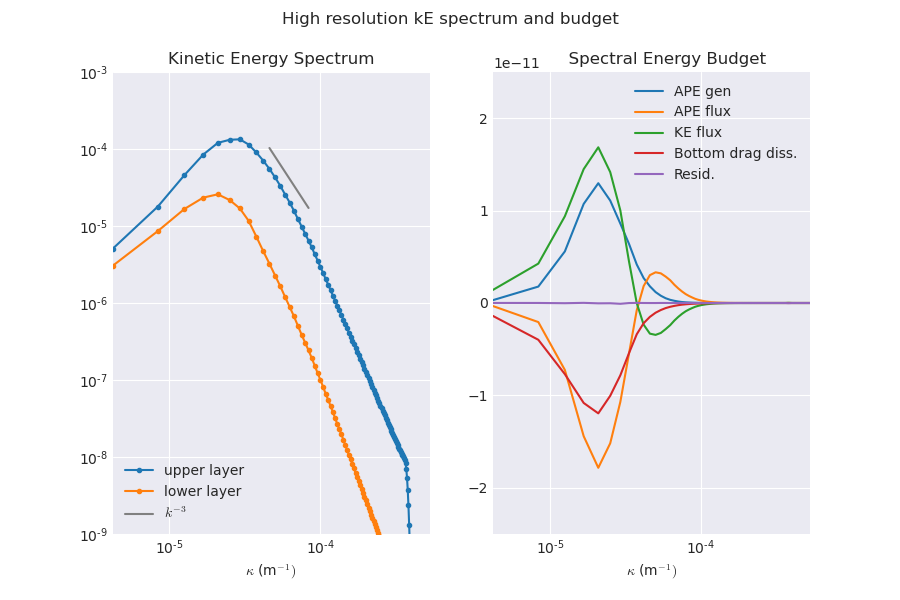

<IPython.core.display.Javascript object>


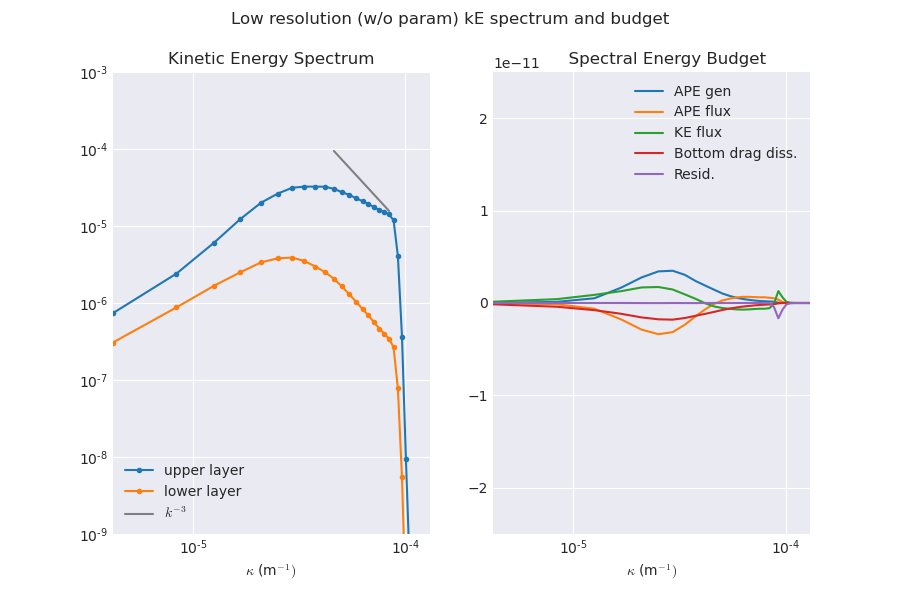

<IPython.core.display.Javascript object>


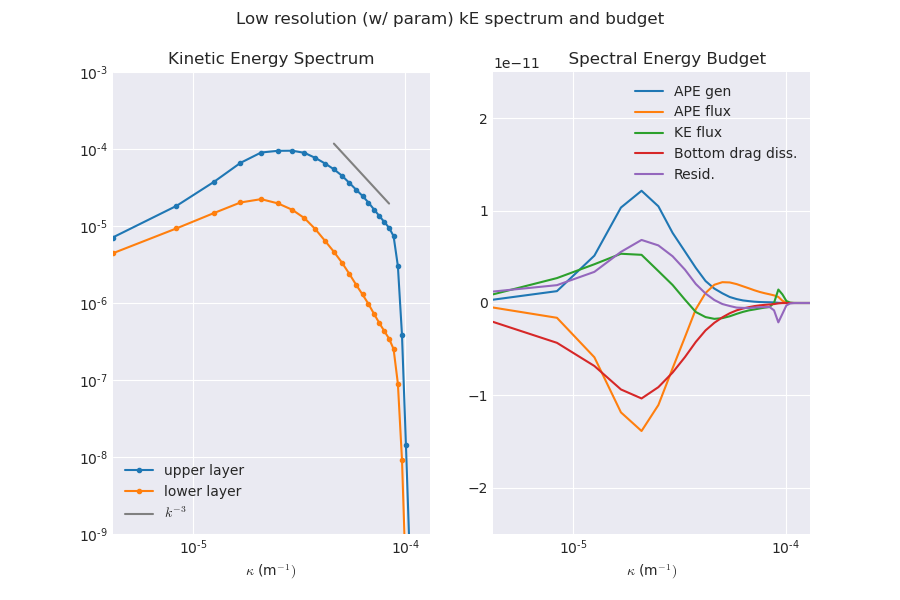

Text(0.5, 0.98, 'Low resolution (w/ param) kE spectrum and budget')

In [18]:
from utils import energy_budget
scale = 0.25e-10
energy_budget(m, ymin=-scale, ymax=scale, figsize=(9, 6), radial=True)
plt.suptitle('High resolution kE spectrum and budget')

energy_budget(m_low, ymin=-scale, ymax=scale, figsize=(9, 6), radial=True)
plt.suptitle('Low resolution (w/o param) kE spectrum and budget')

energy_budget(m_param, ymin=-scale, ymax=scale, figsize=(9, 6), radial=True)
plt.suptitle('Low resolution (w/ param) kE spectrum and budget')


<IPython.core.display.Javascript object>


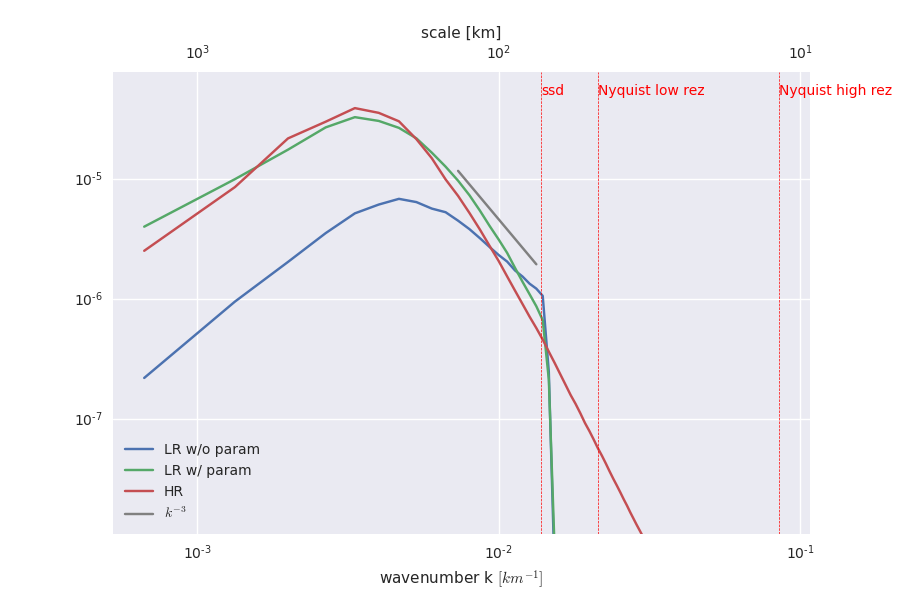

64
64_param
256
1.0895734468576517e-08 7.741294984793316e-05


In [28]:
def text_with_line(x_line, text, y=0.95):
    plt.axvline(x_line, color='r', linestyle='--', linewidth=0.5)
    ax = plt.gca()
    trans = ax.get_xaxis_transform()
    plt.text(x_line, y, text, transform=trans, color='r')

plt.style.use("seaborn")    
fig = plt.figure(figsize=[9, 6])
for i, name in enumerate(names):
    print(name)
    spec = uv[name]['spec']
    k = spec[0]
    spec = spec[1]
    plt.loglog(k, spec)
    if i == len(names) - 1:
        plt.loglog(k[10:20], 2 * (k[10:20] ** -3) *
                   spec[10:20].mean() / (k[10:20] ** -3).mean(),'0.5')
y_min = 1 / 20 * min([spec[0] for spec in [uv[name]['spec'][1] for name in names]])
y_max = 2*np.max(uv['256']['spec'][1])
print(y_min, y_max)
plt.ylim(y_min, y_max)
plt.legend(['LR w/o param', 'LR w/ param', 'HR'] + [r'$k^{-3}$', ])

ax = plt.gca()
plt.xlabel(r'wavenumber k $[km^{-1}]$')

x_line1 = 0.65 / 2 / (uv['64']['model'].dx * 1e-3)
text_with_line(x_line1, 'ssd')

x_line2 = 1 / 2 / (uv['64']['model'].dx * 1e-3)
text_with_line(x_line2, 'Nyquist low rez', 0.95)

x_line3 = 1 / 2 / (uv['256']['model'].dx * 1e-3)
text_with_line(x_line3, 'Nyquist high rez', 0.95)

# ax.set_xticks(list(ax.get_xticks()) + [x_line1, x_line2, x_line3])
secax = ax.secondary_xaxis('top', functions=(lambda x: 1/x, lambda x:1/x))
secax.set_xlabel('scale [km]')


plt.show()

<IPython.core.display.Javascript object>


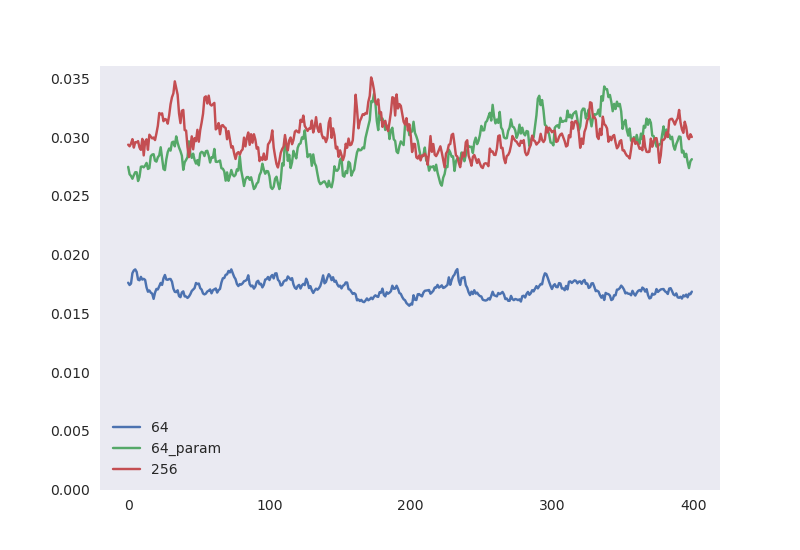

64
64_param
256
256_


(0.0, 0.03605676247065264)

In [30]:
plt.style.use("seaborn-dark")
plt.figure()
for k, v in uv.items():
    print(k)
    if k != '256':
        plt.plot(((v['uv']**2).std(axis=(-1, -2, -3))))
plt.legend(uv.keys())
plt.ylim([0, None])

In [31]:
from numpy.fft import fft
spatial_spectra = dict()
for v in names:
    #var = np.stack((uv[v]['uv'][:, 0, ...], np.zeros_like(uv[v]['uv'][:, 0, ...])), axis=1)
    var = uv[v]['uv']
    spatial_spectra[v] = spatial_spectrum(var, radial=False, co=False)

dx 18.75
dx 18.75
dx 4.6875


In [34]:
plt.style.available[:]

['Solarize_Light2',
 '_classic_test_patch',
 'bmh',
 'classic',
 'dark_background',
 'fast',
 'fivethirtyeight',
 'ggplot',
 'grayscale',
 'seaborn',
 'seaborn-bright',
 'seaborn-colorblind',
 'seaborn-dark',
 'seaborn-dark-palette',
 'seaborn-darkgrid',
 'seaborn-deep',
 'seaborn-muted',
 'seaborn-notebook',
 'seaborn-paper',
 'seaborn-pastel',
 'seaborn-poster',
 'seaborn-talk',
 'seaborn-ticks',
 'seaborn-white',
 'seaborn-whitegrid',
 'tableau-colorblind10']

<IPython.core.display.Javascript object>


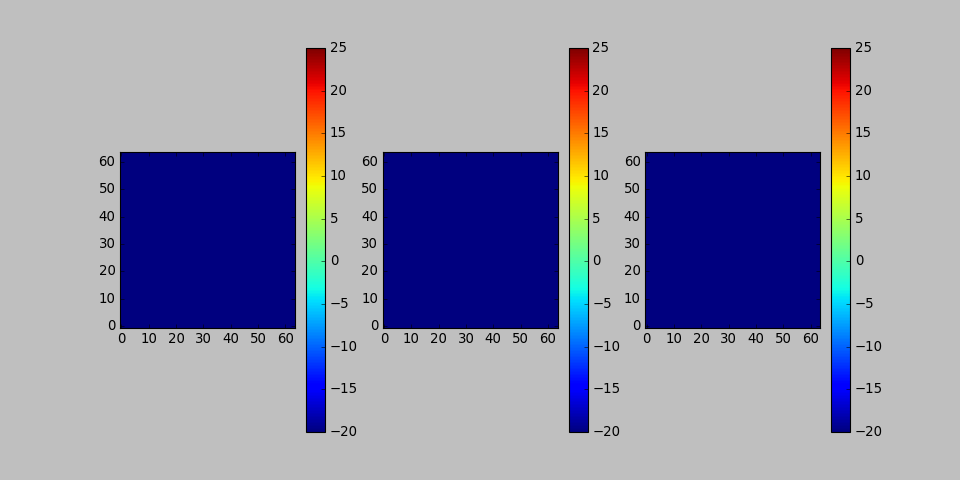

(64, 64)
(64, 64)
(256, 256)


In [36]:
plt.style.use("classic")
plt.figure(figsize=(12, 6))
def same_freq_grid(spec1, spec2):
    shape1 = spec1.shape
    shape2 = spec2.shape
    if shape1[-1] > shape2[-1]:
        spec2, spec1 = same_freq_grid(spec2, spec1)
        return spec1, spec2
    block1 = spec2[..., :shape1[-2] // 2 + 1, :shape1[-1] // 2 + 1]
    block2 = spec2[..., -shape1[-2] // 2 + 1:, :shape1[-1] // 2 + 1]
    block3 = spec2[..., -shape1[-2] // 2 + 1:, -shape1[-1] // 2 + 1:]
    block4 = spec2[..., :shape1[-2] // 2 + 1, -shape1[-1] // 2 + 1:]
    block1 = np.concatenate((block1, block4), axis=-1)
    block2 = np.concatenate((block2, block3), axis=-1)
    result = np.concatenate((block1, block2), axis=-2)
    return spec1, result

for i, v in enumerate(names):
    plt.subplot(1, 3, i + 1)
    spec = spatial_spectra[v]
    print(spec.shape)
    spec, other = same_freq_grid(spec, spatial_spectra['64'])
    plt.imshow(10*np.log10((fftshift(spec))), vmin=-20, vmax=25, origin='lower')
    plt.colorbar()

<IPython.core.display.Javascript object>


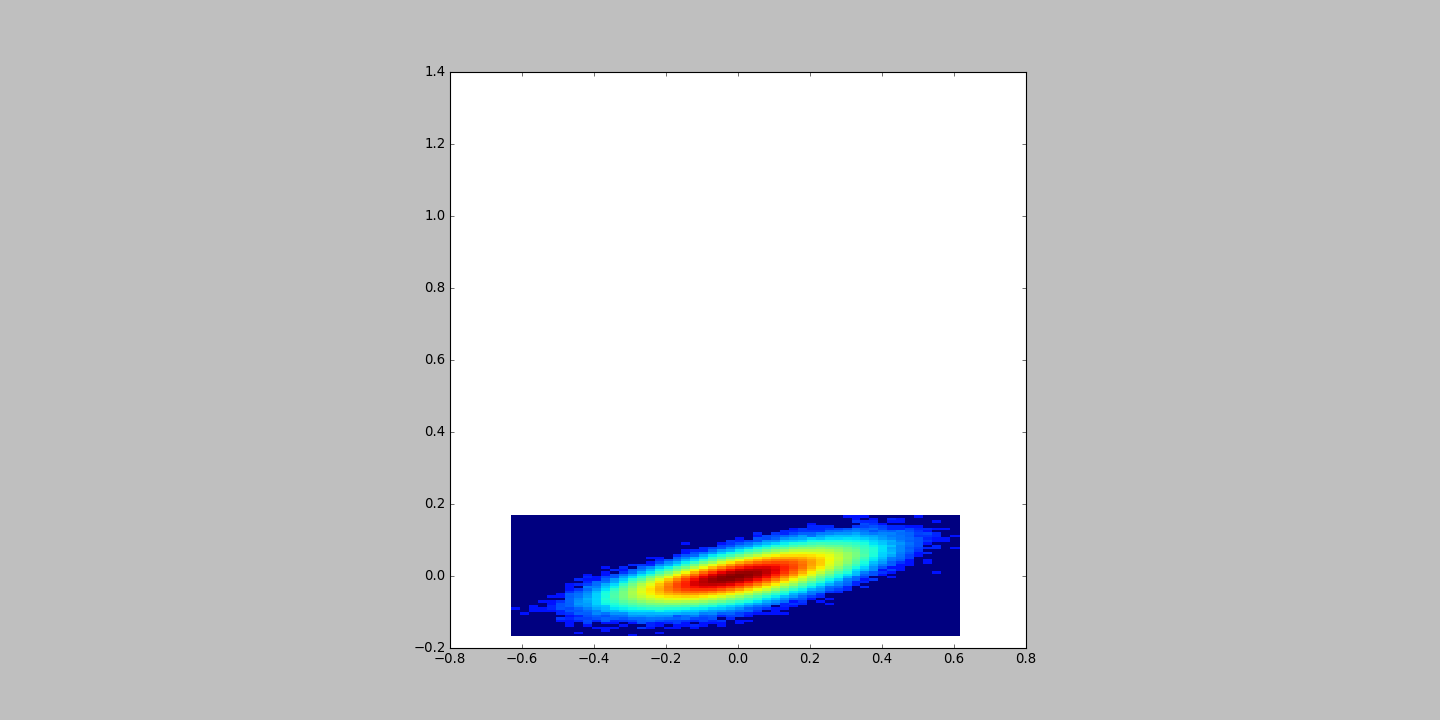

(-0.8, 0.8, -0.2, 1.4000000000000001)

In [37]:
import matplotlib.colors as mcolors
plt.figure(figsize=(18, 9))
plt.hist2d(uv['64']['uv'][:, 0, ...].flatten(), uv['64']['uv'][:, 1, ...].flatten(), bins=50, density=True,
          norm=mcolors.PowerNorm(0.2))
plt.axis('square')

<IPython.core.display.Javascript object>


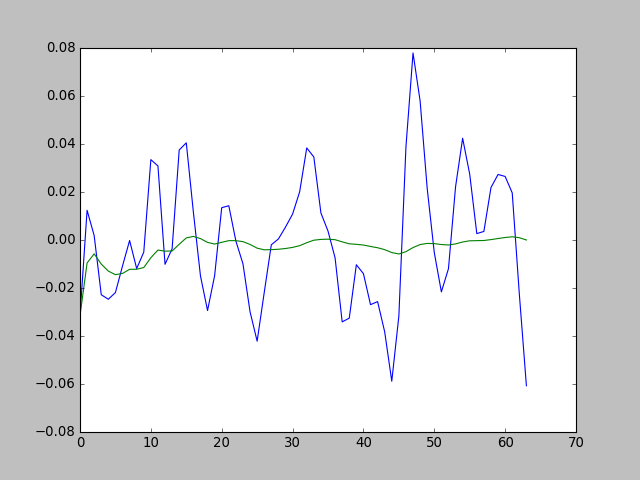

In [38]:
plt.figure()
plt.plot(uv['64']['uv'][-100, 1, :, 62])
plt.plot(np.cumsum(uv['64']['uv'][-100, 1, :, 62]) / np.arange(1, 65))

In [56]:
print(np.mean(uv['64']['uv'][-100, 1, 62, :])**2)
print(spec[62, :10])

8.916196856002925e-06
[2.13297160e-05 2.42453236e-05 2.74959383e-05 3.10744488e-05
 2.54124701e-05 2.42398243e-05 2.56469078e-05 1.15437225e-05
 8.60830266e-06 4.74093687e-06]


<IPython.core.display.Javascript object>


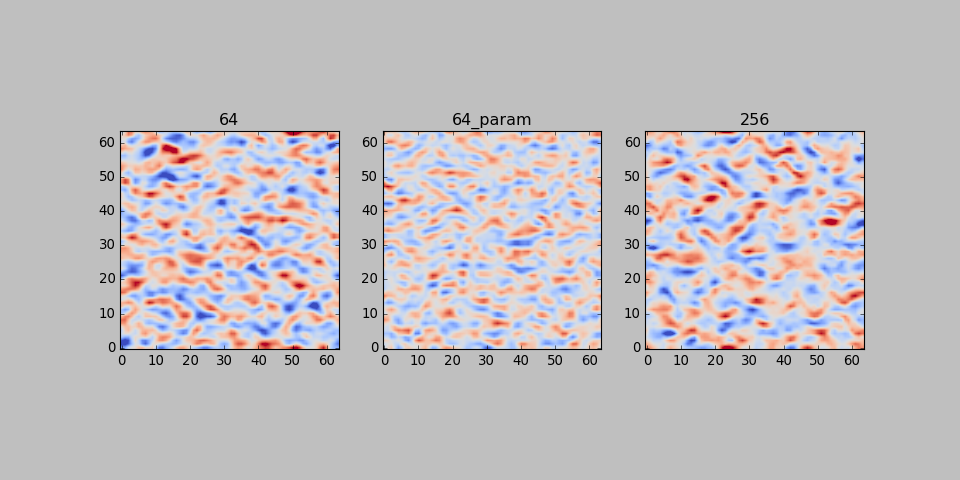

<ipython-input-44-c732bc4da1e8>:15: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  plt.subplot(1, n, i_sub + 1)


In [44]:
from utils import play_movie
def play_movies(predictions: np.ndarray, title: str = '',
               interval: int = 500, vmin=None, vmax=None, cmap='ocean'):
    n = len(predictions)
    nb = predictions[0].shape[0]
    fig = plt.figure(figsize=(12, 6))
    ims = list()
    if vmin is None:
        mean = np.mean(predictions)
        std = np.std(predictions)
        vmin, vmax = mean - 2 * std, mean + 2 * std
    for i in range(nb):
        shows = []
        for i_sub in range(n):
            plt.subplot(1, n, i_sub + 1)
            im = predictions[i_sub][i, ...]
            show = plt.imshow(im, vmin=vmin, vmax=vmax,
                               cmap=cmap,
                               origin='lower', animated=True)
            if i == 0:
                plt.title(names[i_sub])
            shows.append(show)
        ims.append(shows)
    ani = animation.ArtistAnimation(fig, ims, interval=interval, blit=True,
                                    repeat_delay=1000)
    plt.show()
    return ani

ani = play_movies((uv['64_param']['uv'][:, 0, ...], uv['64']['uv'][:, 0, ...], uv['256_']['uv'][:, 0, ...]),
            vmin=-0.4, vmax=0.4, cmap='coolwarm')

<IPython.core.display.Javascript object>


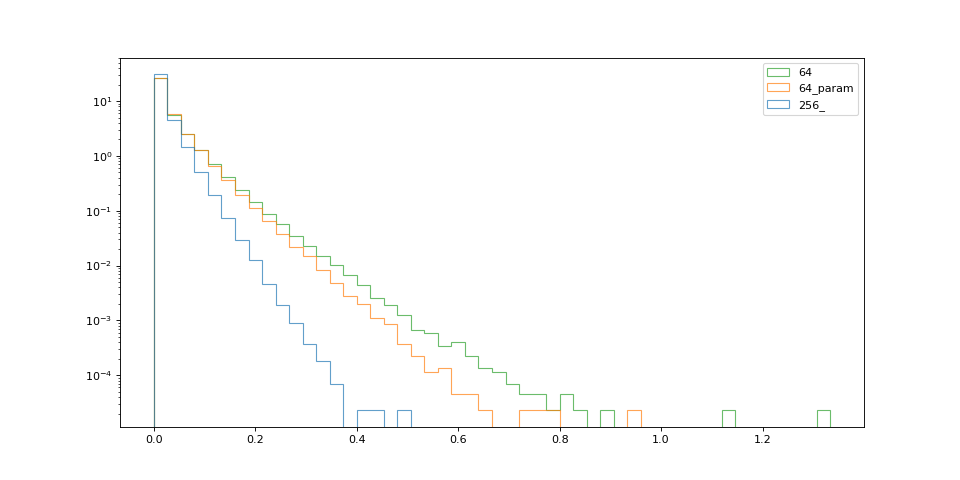

/home/arthur/anaconda3/envs/pyqg/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3357: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  if (await self.run_code(code, result,  async_=asy)):


(1638400, 3)


In [11]:
plt.figure(figsize=(12, 6))
arr = np.stack((uv[name]['uv'][:, 0, ...]**2).flatten() for name in ['64', '64_param', '256_']).T
print(arr.shape)
plt.hist(arr, bins=50, alpha=0.7,
        cumulative=False, log=True, density=True, histtype='step')
plt.legend(['64', '64_param', '256_'])

<IPython.core.display.Javascript object>


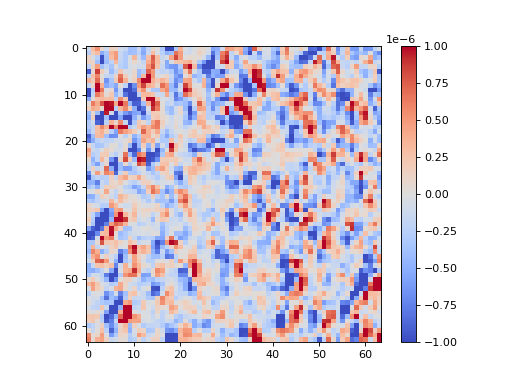

In [31]:
plt.figure()
plt.imshow(uv['64_param']['du'][152, 0], vmin=-1e-6, vmax=1e-6, cmap='coolwarm')
plt.colorbar()

In [30]:
np.mean(uv['64_param']['du'][190, 0])

-6.862985022848028e-08

In [19]:
play_movies((uv['64_1_1param']['dv'][:, 0], ), vmin=-1e-6, vmax=1e-6, cmap='coolwarm', interval=1000)

KeyError: '64_1_1param'

<IPython.core.display.Javascript object>


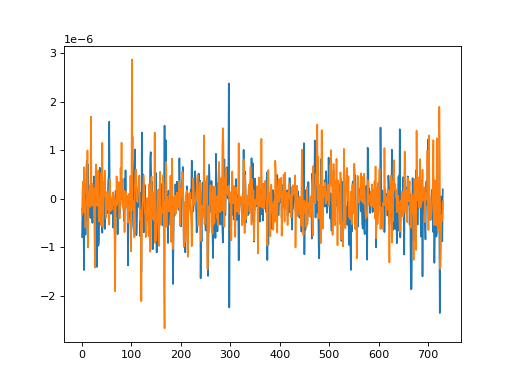

64_param


In [19]:
layer_index = 0
plt.figure()
for name in ('64_param',):
    print(name)
    v = (uv[name]['du'][:, layer_index, 32, 32])
    plt.plot(v)
    v = (uv[name]['dv'][:, layer_index, 32, 32])
    plt.plot(v)

In [21]:
print(uv['64_param']['du'][:, layer_index, 32, 32].mean())
print(uv['64_param']['dv'][:, layer_index, 32, 32].mean())

-1.4347071797250543e-07
-9.643958625361458e-08


(731, 2, 64, 64)
dx 18.75
(64,)


<IPython.core.display.Javascript object>


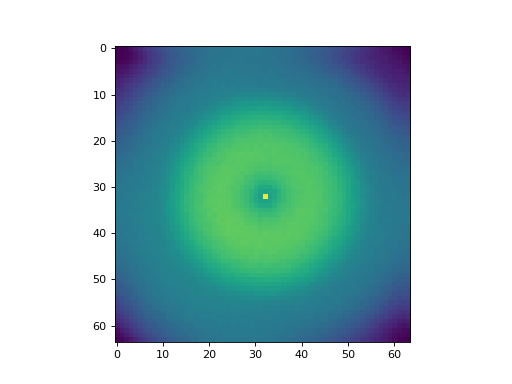

In [14]:
def spatial_spectrum(uv, radial: bool = True, co: bool = False,
                     L: float = 1.2e3):
    if uv.ndim == 3:
        uv = uv.reshape((1,) + uv.shape)
    uv = uv[:, 0, ...] + 1j * uv[:, 1, ...]
    dx = L / uv.shape[-1]
    dy = L / uv.shape[-2]
    print('dx', dx)
    if not co:
        spectrum_2d = dx * dy / (uv.shape[-1] * uv.shape[-2]) * abs(fft2(uv))**2
    else:
        spectrum_2d = dx * dy / (uv.shape[-1] * uv.shape[-2]) * abs(fft2(uv)**2)
    # Time-average of spatial spectra
    spectrum_2d = spectrum_2d.mean(axis=0)
    if not radial:
        return spectrum_2d
    k_x = fftfreq(spectrum_2d.shape[0]) / dx
    k_y = fftfreq(spectrum_2d.shape[1]) / dy
    k_x, k_y = np.meshgrid(k_x, k_y, indexing='ij')
    print('max', np.max(k_x))
    return radial_average_spectrum(k_x, k_y, spectrum_2d)



name = '64_param'
forcing = np.stack((uv[name]['du'][:, 0, ...], uv[name]['dv'][:, 0, ...]), axis=1)
print(forcing.shape)
forcing_spec = spatial_spectrum(forcing, radial=False)
print(forcing_spec[1].shape)
plt.figure()
plt.imshow(fftshift(10*np.log10(forcing_spec)))


In [ ]:
from numpy.fft import fftn
def spatio_temporal_spectrum(uv):
    uv = uv[:, 0, ...] + 1j * uv[:, 1, ...]
    shape = uv.shape
    return 1 / (shape[0] * shape[1] * shape[2])**2 * abs(fftn(uv))**2

sp = spatio_temporal_spectrum(uv['64_param']['uv'])
plt.figure()
plt.imshow(fftshift(np.log(sp.mean(axis=0))))
plt.colorbar()

<IPython.core.display.Javascript object>


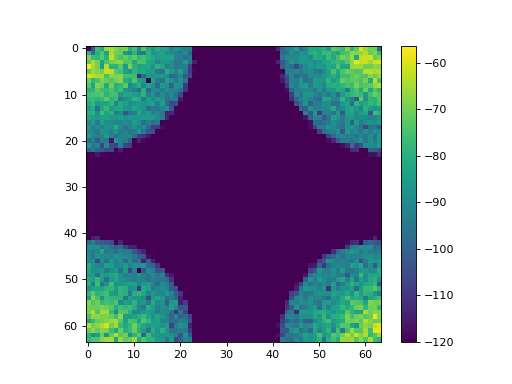

In [22]:
plt.figure()
plt.imshow(10*np.log10((sp[-10, ...])), vmin=-120)
plt.colorbar()

<IPython.core.display.Javascript object>


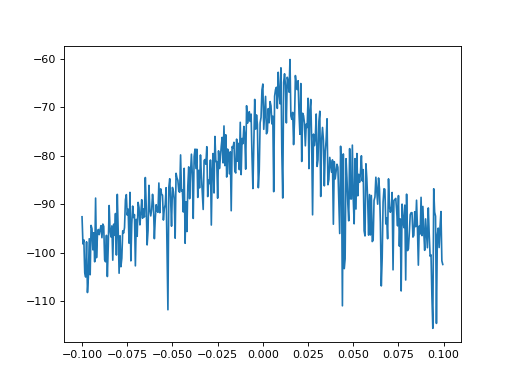

In [23]:
plt.figure()
dt = 5
freq = fftshift(fftfreq(sp.shape[0])) / dt
plt.plot(freq, 10*np.log10(fftshift(sp[:, 2, 2])))

<IPython.core.display.Javascript object>


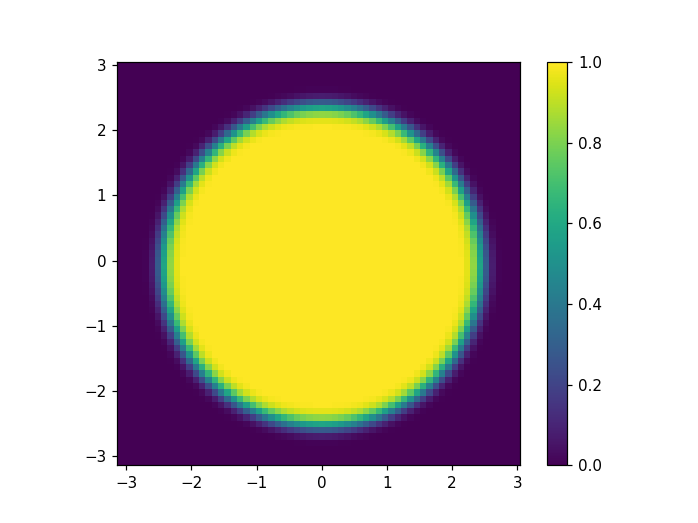

In [24]:
from numpy.fft import fftfreq, fftshift
def _initialize_filter(m, n):
    """Set up frictional filter."""
    # this defines the spectral filter (following Arbic and Flierl, 2003)
    cphi=0.65*np.pi
    k = fftfreq(m) * 2 * np.pi
    l = fftfreq(n) * 2 * np.pi
    k, l = np.meshgrid(k, l, indexing='ij')
    wvx=np.sqrt(k**2. + l**2)
    filtr = np.exp(-18.4*(wvx-cphi)**4)
    filtr[wvx<=cphi] = 1.
    return filtr
k = fftshift(fftfreq(64) * 2 * np.pi)
l = fftshift(fftfreq(64) * 2 * np.pi)
plt.figure()
plt.imshow(fftshift(_initialize_filter(64, 64)), extent=(k[0], k[-1], l[0], l[-1]))
plt.colorbar()

In [ ]:
plt.figure()
    for i, var in enumerate(('', '1')):
        plt.subplot(1, 3, i + 1)
        plt.imshow(10*np.log10(abs(locals()['space' + var])), vmin=-10, vmax=15)
    plt.subplot(1, 3, 3)
    plt.imshow(np.mean(term2, axis=0))
    plt.colorbar()
    plt.figure()
    plt.plot(10*np.log10(time))
    print(np.nanmean(term1))
    print(np.nanmean(term2))

In [15]:
def same_freq_grid(spec1, spec2):
    shape1 = spec1.shape
    shape2 = spec2.shape
    if shape1[-1] > shape2[-1]:
        spec2, spec1 = same_freq_grid(spec2, spec1)
        return spec1, spec2
    block1 = spec2[..., :shape1[-2] // 2 + 1, :shape1[-1] // 2 + 1]
    block2 = spec2[..., -shape1[-2] // 2 + 1:, :shape1[-1] // 2 + 1]
    block3 = spec2[..., -shape1[-2] // 2 + 1:, -shape1[-1] // 2 + 1:]
    block4 = spec2[..., :shape1[-2] // 2 + 1, -shape1[-1] // 2 + 1:]
    block1 = np.concatenate((block1, block4), axis=-1)
    block2 = np.concatenate((block2, block3), axis=-1)
    result = np.concatenate((block1, block2), axis=-2)
    return spec1, result


def kullback_leibler(uv1, uv2, temporal=True):
    spec1 = spatio_temporal_spectrum(uv1)
    spec2 = spatio_temporal_spectrum(uv2)
    spec1, spec2 = same_freq_grid(spec1, spec2)
    if not temporal:
        spec1 = np.mean(spec1, axis=0, keepdims=True)
        spec2 = np.mean(spec2, axis=0, keepdims=True)
    shape = spec1.shape
    spec1 = fftshift(spec1)
    spec2 = fftshift(spec2)
    filter = fftshift(_initialize_filter(shape[1], shape[2]))
    # spec1 *= filter
    freq_x = fftfreq(shape[1]) * shape[1]
    freq_y = fftfreq(shape[2]) * shape[2]
    ks = np.meshgrid(freq_x, freq_y, indexing='ij')
    sel = np.logical_and((ks[0]**2 + ks[1]**2) <= (shape[1] * 0.65 / 2)**2,
                         (ks[0]**2 +ks[1]**2) >=0)
    sel = fftshift(sel)
    sel = sel.reshape((1, sel.shape[0], sel.shape[1]))
    sel = sel.repeat(shape[0], axis=0)
    term1 = spec1 / spec2 
    term2 = - np.log(spec1 / spec2)
    kl_div = term1 + term2 - 1
    term1 = np.where(sel, term1, np.nan)
    term2 = np.where(sel, term2, np.nan)
    kl_div = np.where(sel, kl_div, np.nan)
    filter = filter.reshape((1, filter.shape[0], filter.shape[1]))
    kl_div *= filter
    time = np.nanmean(kl_div, axis=(-1, -2))
    space = np.mean(kl_div, axis=0)
    space1 = np.mean(term1, axis=0)
    space2 = np.mean(term2, axis=0)
    return np.nanmean(kl_div)

print('Without param:')
print(kullback_leibler(uv['256']['uv'][::, ...], uv['64']['uv'][::, ...]))
print('With param:')
print(kullback_leibler(uv['256']['uv'][::, ...], uv['64_param']['uv'][::,...]))

Without param:
573.6359009150376
With param:
17.63472076999725


In [16]:
print('Without param:')
print(kullback_leibler(uv['64']['uv'][:, ...], uv['256']['uv'][:, ...]))
print('With param:')

print(kullback_leibler(uv['64_param']['uv'][:, ...], uv['256']['uv'][:,...]))

Without param:
10.034350894318397
With param:
13.151549209968076


In [33]:
def j_divergence(uv1, uv2, *args):
    return kullback_leibler(uv1, uv2, *args) + kullback_leibler(uv2, uv1, *args)

print('Without param:')
print(j_divergence(uv['256']['uv'], uv['64']['uv']))
print('With param:')
print(j_divergence(uv['256']['uv'], uv['64_param']['uv']))

Without param:
583.670251809356
With param:
30.786269979965326


In [43]:
data_names = ['64_1.2_0.8333333333333334param', '64_1.4_0.7142857142857143param', '64_1.6_0.625param',
              '64_1.8_0.5555555555555556param', '64_2.0_0.5param']

arr = np.zeros(len(data_names))
for i, name in enumerate(data_names):
    u = np.load(path_output_dir / f'video_u_{name}.npy')
    v = np.load(path_output_dir / f'video_v_{name}.npy')
    uv['64_param']['uv'] = np.stack((u[-400:, layer_index, ...],
                               v[-400:, layer_index, ...]), axis=1)
    value = j_divergence(true, uv['64_param']['uv'])
    print(value)
    arr[i] = value
def_value = j_divergence(true, uv['64']['uv'])

(400, 2, 64, 64)
25.596828067404687
(400, 2, 64, 64)
21.30122192204764
(400, 2, 64, 64)
25.171728878383938
(400, 2, 64, 64)
20.373589744807653
(400, 2, 64, 64)
30.786269979965326


<IPython.core.display.Javascript object>


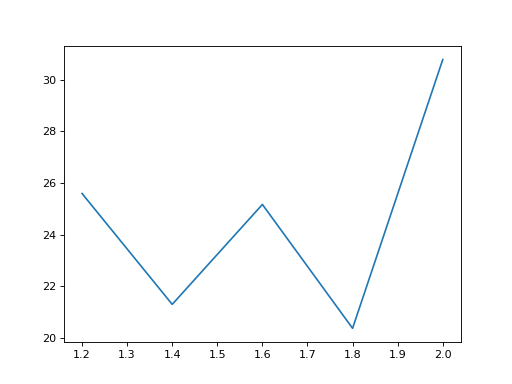

In [44]:
plt.figure()
plt.plot([1.2, 1.4, 1.6, 1.8, 2.0], arr)

In [37]:
true - uv['64_param']['uv']

array([[[[0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         ...,
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.]],

        [[0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         ...,
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.]]],


       [[[0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         ...,
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.]],

        [[0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         ...,
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0.

In [34]:
true = uv['256']['uv']

In [36]:
true.shape

(400, 2, 256, 256)

In [39]:
j_divergence(true, uv['64_param']['uv'])

0.0

In [41]:
uv['64_param']['uv'].shape

(400, 2, 256, 256)